# Results 

## Table of contents

+ [Notebook setup](#notebook-setup)
+ [General remarks](#general-remarks)
+ [Final models](#final-models)
    + Short term outcome
    + Long term outcome
+ [Limitations](#limitations)
+ [Future work](#future-work)

-----

## Notebook setup

In [65]:
import pandas as pd
import numpy as np
from functions import helper
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt


----
## General remarks

## Final models



In [27]:
# encoder for categories
onehot = OneHotEncoder(drop="first")

# scalers for numerical features
mms = MinMaxScaler()
ss = StandardScaler()

# Prepare list of numerical and categorical columns
num_cols = make_column_selector(dtype_include=np.number)
cat_cols = make_column_selector(dtype_include='category')

### Short term outcome

In [71]:
# get the data
df = pd.read_csv('data/IST_corrected_clean.csv',  index_col= [0])

# Reset the index
df.index = pd.RangeIndex(len(df.index))

# drop missing values from 'RATRIAL'
df = df.dropna(subset = ['RATRIAL'])

# transform target into 1/0 
df['DDEAD'] = df.DDEAD == 'Y'

# Select features
features = ['AGE', 'RSBP', 'SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']
X = df[features]

# Select target
y = df.DDEAD

In [72]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [73]:
#convert all 'objects' into 'categories'
X_train = pd.concat([
        X_train.select_dtypes([], ['object']),
        X_train.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_train.columns, axis=1)

In [74]:
#convert all 'objects' into 'categories' 
X_test = pd.concat([
        X_test.select_dtypes([], ['object']),
        X_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_test.columns, axis=1)

In [75]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", mms, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

# Oversmapling and Undersampling
sme = SMOTEENN(random_state= 42)
X_train_trans_r, y_train_r = sme.fit_resample(X_train_trans, y_train)

In [76]:
# Calculate the LogisticRegression
logreg = LogisticRegression(max_iter=400)
logreg_pipe = make_pipeline(sme, logreg)

              precision    recall  f1-score   support

       False       0.96      0.70      0.80      4797
        True       0.21      0.72      0.33       550

    accuracy                           0.70      5347
   macro avg       0.58      0.71      0.57      5347
weighted avg       0.88      0.70      0.76      5347

[[3334 1463]
 [ 153  397]]
Misclassified samples: 1616
F1-Score : 0.3295


(Pipeline(steps=[('smoteenn', SMOTEENN(random_state=42)),
                 ('logisticregression', LogisticRegression(max_iter=400))]),
 array([ True, False,  True, ..., False, False, False]))

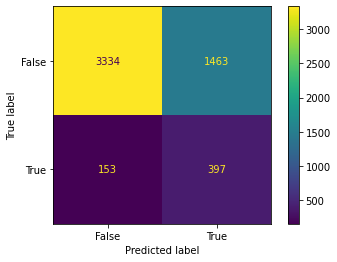

In [77]:
helper.pred_model(logreg_pipe, X_train_trans_r, X_test_trans, y_train_r, y_test)

This was the model with the best recall (and accuracy). Let's have a closer look at the features. Which are the most important ones?

In [78]:
X_train_trans = pd.DataFrame(X_train_trans)

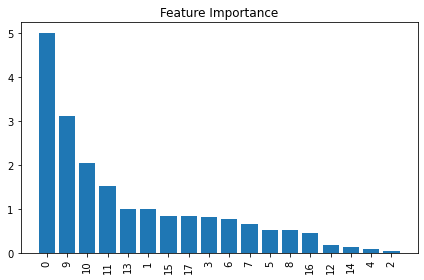

In [79]:
importances = abs(logreg.coef_[0])

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train_trans.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train_trans.shape[1]), X_train_trans.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [39]:
print(importances)
sorted_indices

[4.98572028 0.99184362 0.0448224  0.80952749 0.09102709 0.52016851
 0.77094366 0.6524992  0.51823147 3.12108047 2.03849156 1.53315962
 0.18306139 1.00703003 0.13249219 0.85106457 0.46234898 0.83954802]


array([ 0,  9, 10, 11, 13,  1, 15, 17,  3,  6,  7,  5,  8, 16, 12, 14,  4,
        2])

When converting the numerical and categorical data, we first used the numerical ones. Thus feature 0 is AGE and feature 1 is RSBP. In this regard, the following features are the categorical ones but encoded. Thus, features 9, 10, and 11 are the severe deficits encoded. 

### Long term outcome

The best model to predict the long term outcome was Random Forest. We will set it up again and check which features are the most important ones for the prediction.


In [52]:
# Get the data
df = pd.read_csv('data/IST_corrected_clean.csv',  index_col= [0])

# Reset the index
df.index = pd.RangeIndex(len(df.index))

# drop all participants that passed away within 14 days
df = df[df['DDEAD'] != 'Y']

In [53]:
def target(row):
    if row.OCCODE == 'Recovered':
        return 0
    elif row.OCCODE in ['Not recovered', 'Dependent', 'Dead']:
        return 1
    else:
        return np.nan

In [54]:
# Create the new target column
df['NOREC'] = df.apply(lambda row: target(row), axis=1)

In [55]:
# drop missing values from 'RATRIAL'
df = df.dropna(subset = ['RATRIAL'])

In [56]:
# convert NCB14 and STRK14 into categoricals
df['NCB14'] = df.NCB14.astype('object')
df['STRK14'] = df.STRK14.astype('object')

# Select features
features = ['SEX', 'AGE', 'RSBP', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'NCB14', 'STRK14', 'RATRIAL']
X = df[features]

# Select target NOREC
y = df.NOREC

In [57]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
#convert all 'objects' into 'categories'
X_train = pd.concat([
        X_train.select_dtypes([], ['object']),
        X_train.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_train.columns, axis=1)

In [59]:
#convert all 'objects' into 'categories' 
X_test = pd.concat([
        X_test.select_dtypes([], ['object']),
        X_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_test.columns, axis=1)

In [60]:
# oversampling and undersampling
sme = SMOTEENN(random_state= 42)

In [61]:
# Encode categorical features
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL', 'NCB14', 'STRK14']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

              precision    recall  f1-score   support

           0       0.29      0.19      0.23       921
           1       0.82      0.89      0.86      3862

    accuracy                           0.76      4783
   macro avg       0.56      0.54      0.54      4783
weighted avg       0.72      0.76      0.73      4783

[[ 172  749]
 [ 417 3445]]
Misclassified samples: 1166
F1-Score : 0.8553


(RandomForestClassifier(class_weight='balanced', random_state=42),
 array([1, 0, 1, ..., 1, 1, 1]))

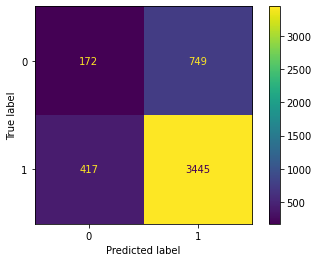

In [66]:
# Random Forest Classifier
rf_w = RandomForestClassifier(random_state = 42, class_weight= 'balanced')

helper.pred_model(rf_w, X_train_trans, X_test_trans, y_train, y_test)

This was the model with the best recall (and accuracy). Let's have a closer look at the features. Which are the most important ones?

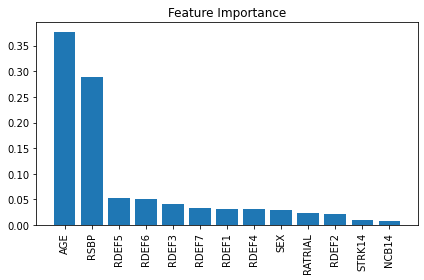

In [67]:
importances = rf_w.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

The most important features are the age and systolic blood pressure of the patient. These are followed by the sever deficits of hemianopia and visuospatial disorder as well as all other deficits that have about the same influence as sex and atrial fibrillation.

## Conclusions

We were able to build one model to predict the short term and one model to predict the long term outcome of stroke patients. Both models were primiarly driven by the age of the participants as well as hemianopia and visuospatial disorder. In both models the systolic blood pressure had an effect, but to differing degrees.

## Limitations

The dataset contains only a small number of features that may be able to predict the risk for patients to receive a recurrent stroke or other detrimental health conditions. Strokes are known to be influenced by high blood pressure (which was included in the data), though smoking poses a high risk for patients. In fact, women are particularly prone to strokes if they smoke and use certain birth control medicines ([source](https://www.cdc.gov/stroke/women.htm)). People who tend to be obese and or have a high blood sugar are also at risk.

## Future Work

The International Stroke Trial has been continued and also extended in terms of variables. It is worth to look into the dataset. More information can be found [here](https://www.ed.ac.uk/clinical-brain-sciences/research/completed-studies-trials/ist-3-trial).